In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc

In [2]:
# Load the data
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# 1. Data Loading and Initial Inspection

In [3]:
# Show first rows of data set:
print(df.head())
# Show data type of each column:
print(df.info())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

# 2. Data Overview

In [4]:
#Show amount of rows and columns:
print(df.shape)
# Show statistical summary of each data set column:
print(df.describe())
# Show amount of empty cells in data set per column:
print(df.isnull().sum())

(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271

## Insights:

**Time**: Since the unit of measure is seconds, the data set covers roughly 48 hours (or 2 days) of credit card transactions.

**Class**: Value for mean (around 0.002) already shows to small fraction of class fraud (value: 1) compared to the amount of non-fraudulent transactions (value: 0)

**NULL**: There are no empty cells in the data set.

# 3. Class Distribution

Class distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


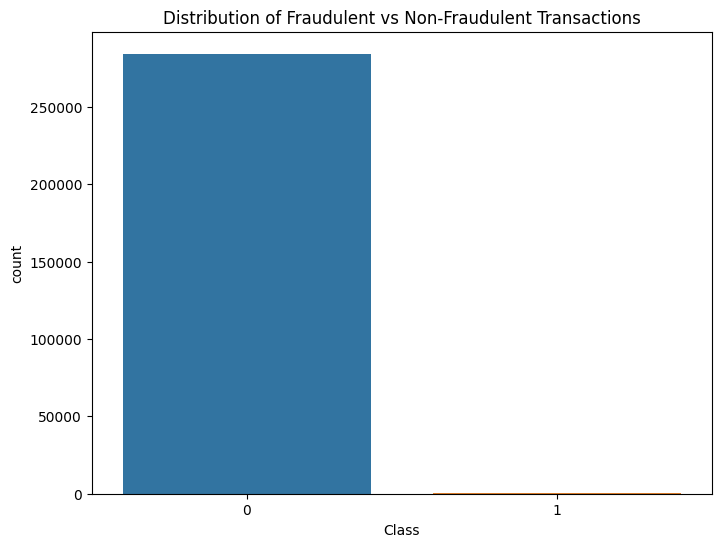

In [5]:
fraud_dist = df['Class'].value_counts(normalize=True)
print("Class distribution:")
print(fraud_dist)

plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

# 4. Feature Analysis

<Figure size 1200x600 with 0 Axes>

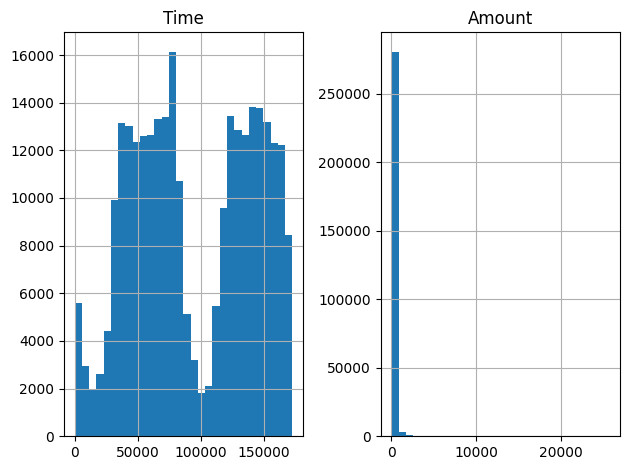

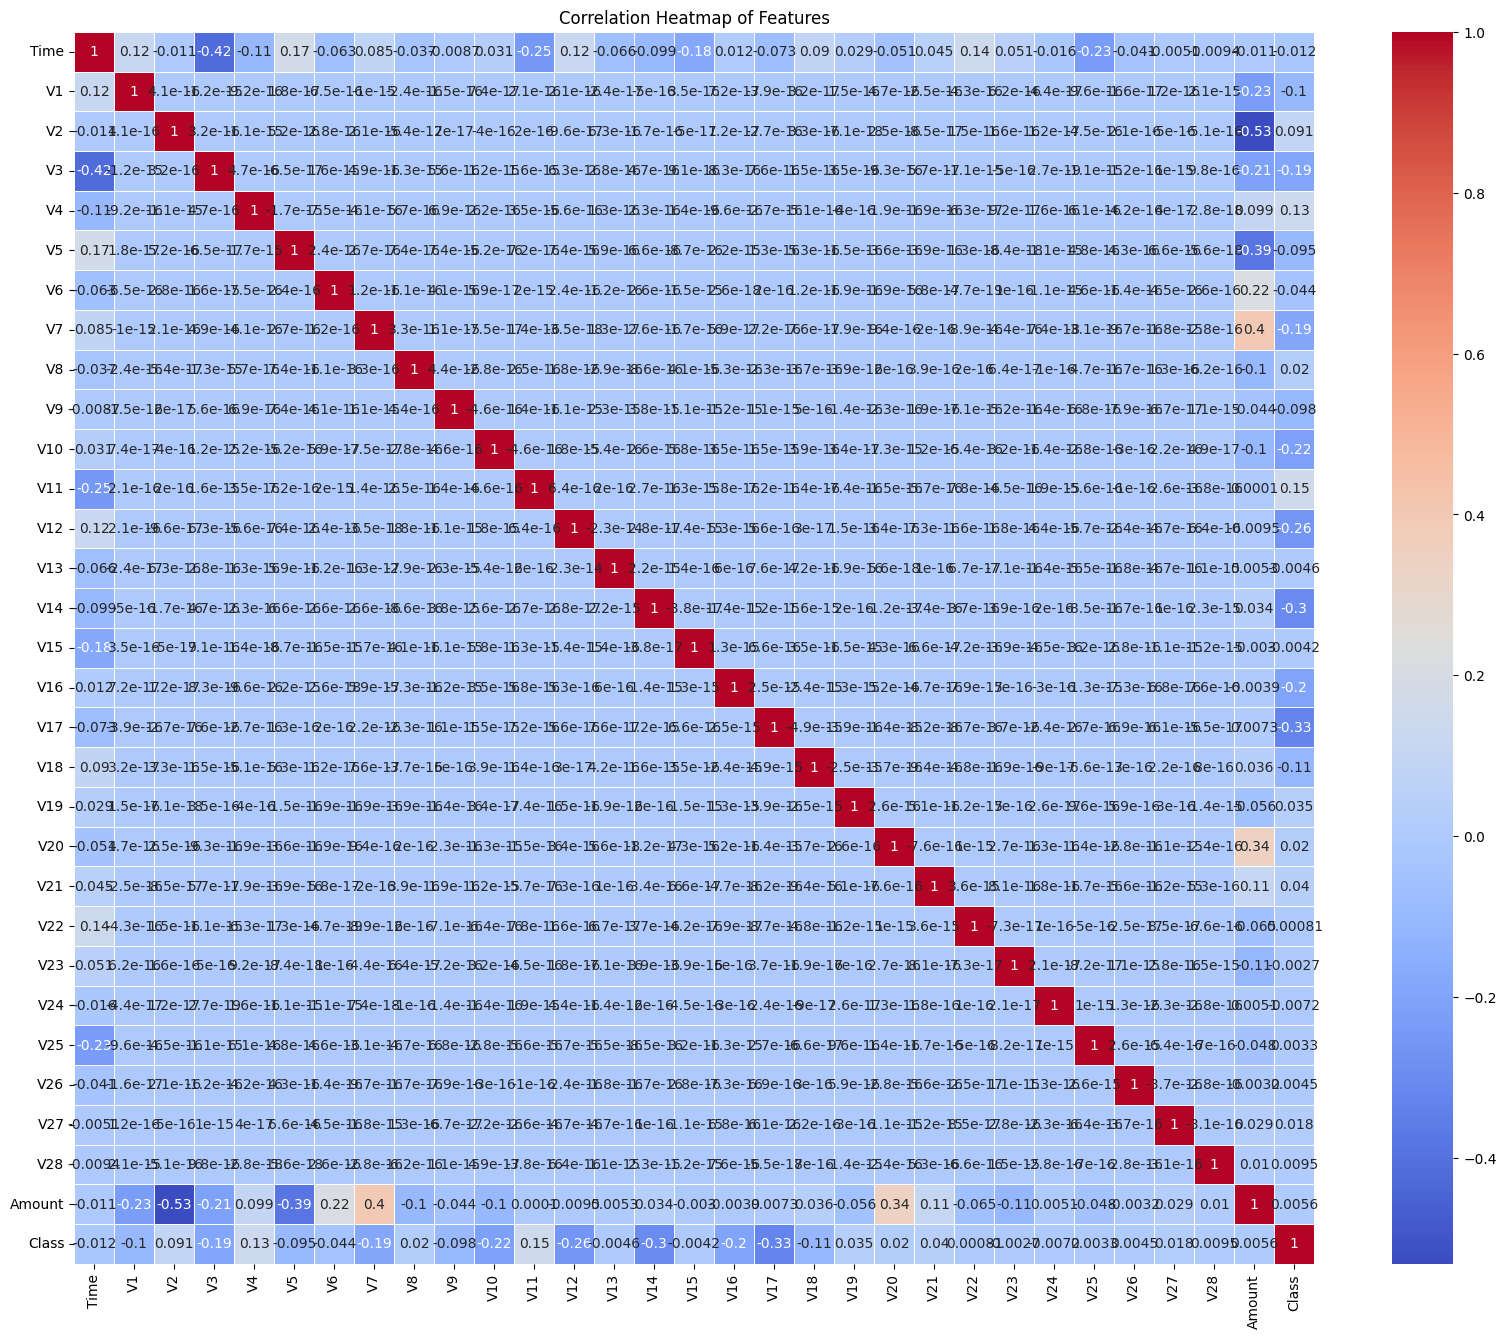

In [6]:
plt.figure(figsize=(12, 6))
df[['Time', 'Amount']].hist(bins=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# 5. Time-based Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


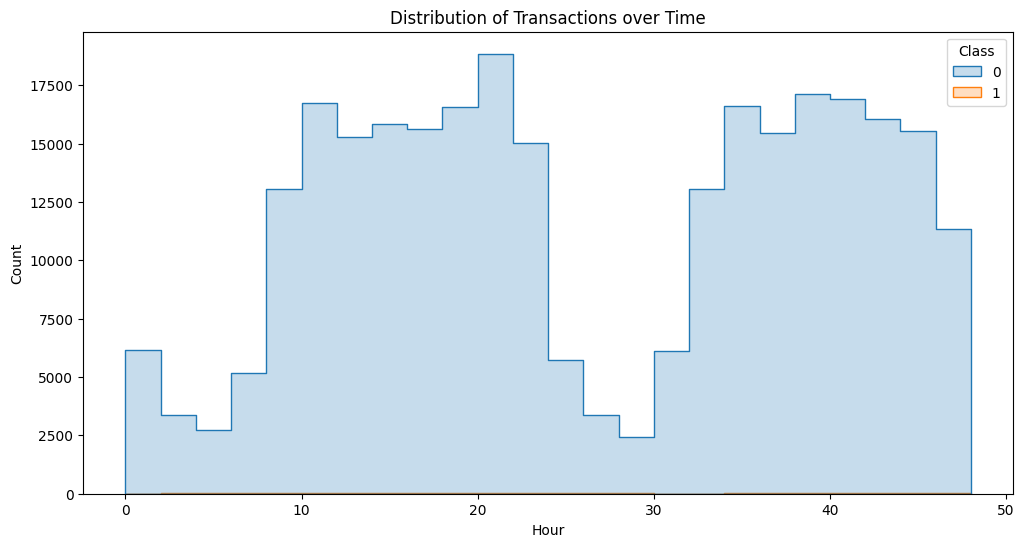

In [7]:
plt.figure(figsize=(12, 6))
df['Hour'] = df['Time'] / 3600  # Convert seconds to hours
sns.histplot(data=df, x='Hour', hue='Class', bins=24, element='step')
plt.title('Distribution of Transactions over Time')
plt.show()

# 6. Amount Analysis

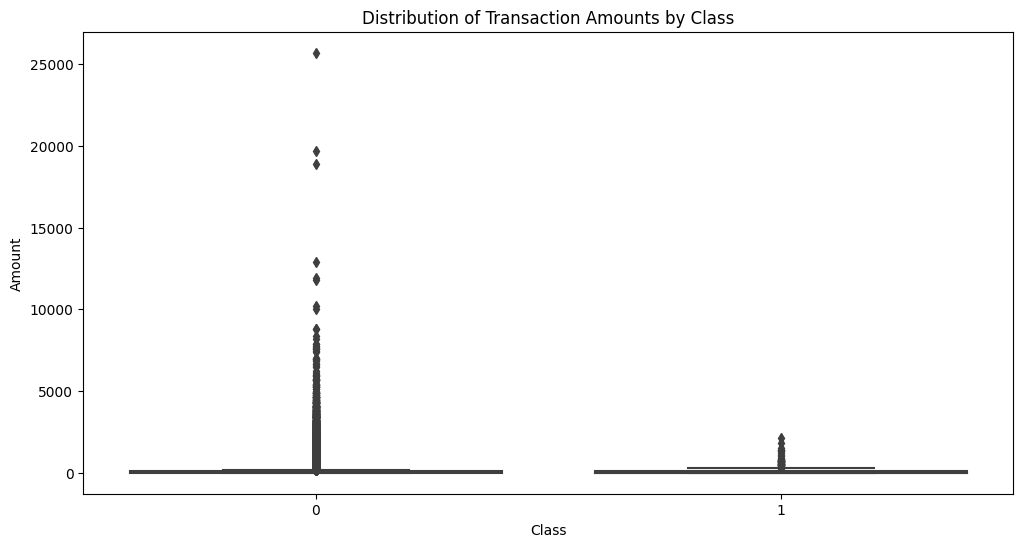

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Distribution of Transaction Amounts by Class')
plt.show()

## Insights

- Frauds are only in small transaction amounts (> 2500 or so)

# 7. Baseline AUPRC calculation

In [9]:
# Create predictions based on the rule: Amount < 2500 is considered fraud
y_true = df['Class']
y_pred = (df['Amount'] < 2500).astype(int)

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Calculate area under the precision-recall curve
auprc = auc(recall, precision)

print(f"Area Under the Precision-Recall Curve: {auprc:.4f}")

Area Under the Precision-Recall Curve: 0.5009


## Insights

I guess the above with an AUPRC value of 0.5 would be a baseline model to beat, initially.

# 8. Model Training

In [10]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

In [11]:
# Data Preprocessing
# Feature Scaling
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

In [12]:
# Splitting the data into training and testing sets
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [13]:
# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
# Model Evaluation
y_pred_proba = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auprc = auc(recall, precision)
print("Area Under the Precision-Recall Curve (AUPRC):", auprc)

Area Under the Precision-Recall Curve (AUPRC): 0.8694619167699201


In [15]:
# Output some samples
sample_indices = np.random.choice(X_test.index, size=5, replace=False)
sample_data = X_test.loc[sample_indices]
sample_predictions = model.predict(sample_data)
sample_probabilities = model.predict_proba(sample_data)[:, 1]

print("\nSample Outputs:")
for i, idx in enumerate(sample_indices):
    print(f"Sample {i+1}:")
    print(f"Data: {sample_data.loc[idx].values}")
    print(f"Predicted Class: {sample_predictions[i]}")
    print(f"Predicted Probability of Fraud: {sample_probabilities[i]:.4f}\n")



Sample Outputs:
Sample 1:
Data: [ 1.17821000e+05  2.32099303e+00 -1.23435428e+00 -1.07473813e+00
 -1.61762271e+00 -9.29323456e-01 -5.04631859e-01 -9.94508235e-01
 -2.39644479e-01 -1.38886151e+00  1.53988771e+00 -9.13523708e-01
 -3.20662881e-01  1.41618390e+00 -6.01054639e-01 -2.31377268e-01
 -6.73356530e-01  4.55782508e-01 -2.89401883e-01 -1.49735974e-01
 -3.66515102e-01 -1.68853660e-01  7.28298405e-02  2.49039338e-01
  6.11546132e-01 -1.12102976e-01 -1.86739904e-01  1.43378065e-02
 -4.48876669e-02 -3.13248531e-01  3.27280556e+01]
Predicted Class: 0
Predicted Probability of Fraud: 0.0000

Sample 2:
Data: [ 1.42060000e+05 -1.16095149e+00  5.23399646e-01  8.54679514e-01
 -2.86368035e+00  4.20322767e-02 -1.05321892e+00  7.57905197e-01
  1.20037782e-01  8.58559540e-01 -1.82895239e+00  4.85067003e-01
  6.66333411e-01 -1.37610673e+00  4.30563717e-01 -1.10026364e+00
 -8.16652443e-01 -1.60689565e-01  3.53900822e-01  7.18676414e-01
 -2.50218535e-01  1.47461883e-01  5.67826933e-01 -6.24320771e-

In [16]:
# Output a sample where fraud is predicted
fraud_found = False
for idx in X_test.index:
    sample_data = X_test.loc[idx].values.reshape(1, -1)
    sample_prediction = model.predict(sample_data)[0]
    sample_probability = model.predict_proba(sample_data)[0, 1]
    
    if sample_prediction == 1:  # Fraud predicted
        fraud_found = True
        print("\nSample Output:")
        print(f"Data: {sample_data.flatten()}")
        print(f"Predicted Class: {sample_prediction}")
        print(f"Predicted Probability of Fraud: {sample_probability:.4f}\n")
        break

if not fraud_found:
    print("No fraud cases were predicted in the test set.")


Sample Output:
Data: [ 4.15050000e+04 -1.65265066e+01  8.58497180e+00 -1.86498532e+01
  9.50559352e+00 -1.37938185e+01 -2.83240430e+00 -1.67016943e+01
  7.51734390e+00 -8.50705864e+00 -1.41101844e+01  5.29923635e+00
 -1.08340065e+01  1.67112025e+00 -9.37385858e+00  3.60805642e-01
 -9.89924654e+00 -1.92362924e+01 -8.39855199e+00  3.10173537e+00
 -1.51492344e+00  1.19073869e+00 -1.12767001e+00 -2.35857877e+00
  6.73461329e-01 -1.41369967e+00 -4.62762361e-01 -2.01857525e+00
 -1.04280417e+00  1.10283362e+00  1.15291667e+01]
Predicted Class: 1
Predicted Probability of Fraud: 0.9700



/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [17]:
# Output a sample where fraud is predicted but it is actually not fraud (false positive)
false_positive_found = False
for idx in X_test.index:
    sample_data = X_test.loc[idx].to_frame().T  # Ensure sample_data retains feature names
    sample_prediction = model.predict(sample_data)[0]
    sample_probability = model.predict_proba(sample_data)[0, 1]
    actual_class = y_test.loc[idx]
    
    if sample_prediction == 1 and actual_class == 0:  # Fraud predicted but actually not fraud
        false_positive_found = True
        print("\nSample Output (False Positive):")
        print(f"Data: {sample_data.values.flatten()}")
        print(f"Predicted Class: {sample_prediction}")
        print(f"Actual Class: {actual_class}")
        print(f"Predicted Probability of Fraud: {sample_probability:.4f}\n")
        break

if not false_positive_found:
    print("No false positive cases were found in the test set.")


Sample Output (False Positive):
Data: [ 3.47000000e+02 -1.53127112e+00  1.39962086e+00 -5.87061395e-01
  2.17500166e+00 -2.13763692e+00 -5.01576168e-01 -1.21521506e+00
  9.56861641e-01 -1.86656120e+00 -2.31102388e+00  2.77010079e+00
 -2.36104985e+00 -5.29229059e-01 -2.00337458e+00  6.19597258e-01
 -2.48907340e+00 -4.88759816e+00 -1.06963619e+00  1.33553998e+00
  8.05861662e-01  5.57904081e-01  8.52670659e-02  4.03095847e-01
  4.54437544e-01  2.02522072e-01 -3.13117525e-01  5.27182018e-01
  2.02574986e-01  4.62500133e-01  9.63888889e-02]
Predicted Class: 1
Actual Class: 0
Predicted Probability of Fraud: 0.5900



## Deep Learning

In [18]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense


In [19]:
# Define the model
model = Sequential()
model.add(Dense(units=128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


I0000 00:00:1726086921.165250      69 service.cc:145] XLA service 0x78ac1c0016c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726086921.165313      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 100/7121 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9841 - loss: 33.5891

I0000 00:00:1726086922.600550      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7121/7121 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9966 - loss: 2.9672
Epoch 2/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9982 - loss: 0.1410
Epoch 3/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9971 - loss: 4.9283
Epoch 4/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9980 - loss: 0.1860
Epoch 5/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9983 - loss: 0.0258
Epoch 6/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9983 - loss: 0.0186
Epoch 7/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9982 - loss: 0.0130
Epoch 8/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9981 - loss: 0.0435
Epoch 9/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9983 - loss: 0.0163
Epoch 10/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9980 - loss: 0.1031


In [21]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)

print(f'Area Under the Precision-Recall Curve (AUPRC): {auprc}')

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Area Under the Precision-Recall Curve (AUPRC): 0.5008602226045433
